In [73]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from numpy import mean, std

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier


In [74]:
# load in the dataset
features = pd.read_csv('heloc_dataset_v1.csv')
features.replace([-9, -8, -7], np.nan, inplace=True)

# the columns that stores the labels
labelDimension = "RiskPerformance"

original_rows = features.shape[0]

features = features.dropna(thresh=10) # Remove rows with more than 10 missing values
print("Removed rows:", original_rows - features.shape[0])
features.drop(features.columns[features.isnull().sum() > 1000], axis=1, inplace=True) # Drop columns with more than 1000 values missing

# bins = [0, 20, 40, 60, 80, 100]
# labels =[0, 1, 2, 3, 4]
# features['ExternalRiskEstimateCat'] = pd.cut(features['ExternalRiskEstimate'], bins, labels=labels)

categorical = [
#     'ExternalRiskEstimateCat', 
    'MaxDelqEver', 
    'MaxDelq/PublicRecLast12M'
]

X = features[features.columns[1:]]
numerical = [col for col in X.columns if col not in categorical]

y = features[labelDimension]
y_code = y.astype("category").cat.codes # Int representation of labels
for cat in categorical:
    X[cat] = X[cat].astype("category")

Removed rows: 588


C:\Users\adubo\AppData\Local\Temp\ipykernel_40748\3794794188.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[cat] = X[cat].astype("category")
C:\Users\adubo\AppData\Local\Temp\ipykernel_40748\3794794188.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[cat] = X[cat].astype("category")


In [75]:
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

model = RandomForestClassifier(n_estimators = 1500)

num_pipe = make_pipeline(SimpleImputer(strategy='mean'), StandardScaler())
cat_pipe = make_pipeline(SimpleImputer(strategy='most_frequent'), OrdinalEncoder())
transformer = ColumnTransformer(transformers=[('num', num_pipe, numerical), ('cat', cat_pipe, categorical)])

In [89]:
X_train, X_test, y_train, y_test = train_test_split(X, y_code, stratify=y_code, train_size = 0.8, random_state=0)

columns = list(numerical) + list(categorical)

X_transform = pd.DataFrame(transformer.fit_transform(X), columns=columns)

X_train_transformed, X_test_transformed, y_train_code, y_test_code = train_test_split(X_transform, y_code, stratify=y_code, train_size = 0.8, random_state=0)

In [107]:
model.fit(X_train_transformed, y_train_code)
y_pred = model.predict(X_test_transformed)
labelled_correctly = y_pred == y_test_code
y_pred_prob = model.predict_proba(X_test_transformed)[:, 1]

C:\Users\adubo\AppData\Local\Temp\ipykernel_40748\1486367421.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(columns)


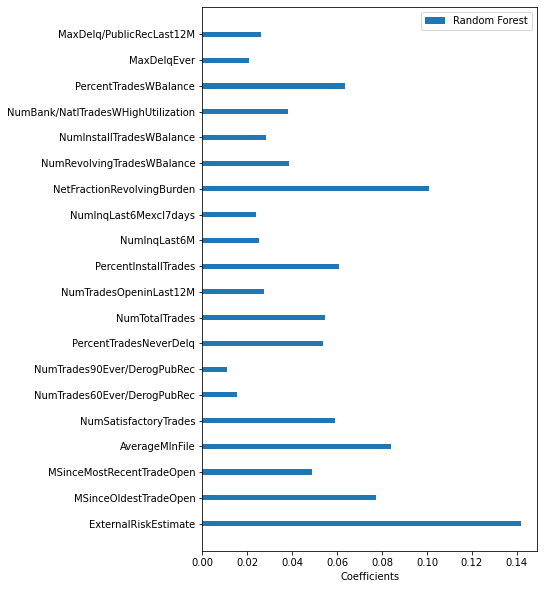

In [78]:
# Feature importances
df = pd.DataFrame({'names': columns, 
                   'random_forest': model.feature_importances_})

fig, ax = plt.subplots(figsize=(6, 10))
ind = np.arange(len(df))
width = 0.2
ax.barh(ind, df.random_forest, width, label='Random Forest')
ax.set_yticklabels(columns)
ax.set_yticks(np.arange(len(columns)))
ax.set_xlabel('Coefficients')
ax.legend()
plt.show()

Text(0.5, 1.0, 'Permutation Importances (test set)')

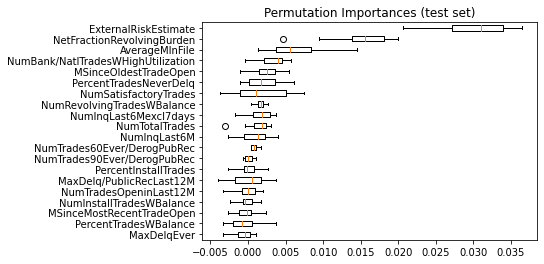

In [79]:
# Permutation Importances
from sklearn.inspection import permutation_importance
 
perm_importance = permutation_importance(model, X_test_transformed, y_test_code, n_repeats=10, random_state=0)
sorted_idx = perm_importance.importances_mean.argsort()
plt.boxplot(perm_importance.importances[sorted_idx].T, vert=False, labels=np.array(columns)[sorted_idx])
plt.title("Permutation Importances (test set)")

In [93]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt 

X_embed = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(X_test_transformed)

In [81]:
# from sklearn.cluster import KMeans
# kmeans = KMeans(n_clusters=4).fit(X_test_transformed)
# clustering_labels = kmeans.labels_
# plt.scatter(X_embed[:, 0], X_embed[:, 1], c=clustering_labels, s=1)
# plt.colorbar()

In [82]:
# from sklearn.cluster import DBSCAN
# dbscan = DBSCAN(eps=5, min_samples=20).fit(X_test_transformed)
# clustering_labels = dbscan.labels_

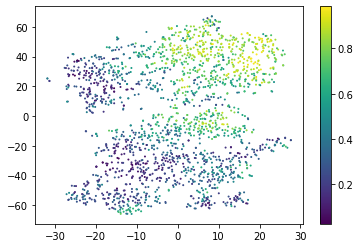

In [108]:
# labels = X_test['ExternalRiskEstimate'].tolist()
# Plot prediction probabilities across samples
plt.scatter(X_embed[:, 0], X_embed[:, 1], c=y_pred_prob, s=1)
plt.colorbar()

In [ ]:
from sklearn.decomposition import PCA
import plotly.express as px


pca = PCA()
components = pca.fit_transform(X_test)
labels = {
    str(i): f"PC {i+1} ({var:.1f}%)"
    for i, var in enumerate(pca.explained_variance_ratio_ * 100)
}

fig = px.scatter_matrix(
    components,
    labels=labels,
    dimensions=range(4),
    color=y_test
)
fig.update_traces(diagonal_visible=True)
fig.show()

In [ ]:
pca = PCA(n_components=2)
components = pca.fit_transform(X_test)

loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

fig = px.scatter(components, x=0, y=1, color=labelled_correctly)

for i, dim in enumerate(X.columns.tolist()):
    fig.add_shape(
        type='line',
        x0=0, y0=0,
        x1=loadings[i, 0],
        y1=loadings[i, 1]
    )
    fig.add_annotation(
        x=loadings[i, 0],
        y=loadings[i, 1],
        ax=0, ay=0,
        xanchor="center",
        yanchor="bottom",
        text=dim,
    )
fig.show()

In [ ]:
# TODO: DiCE counterfactual explanations

In [ ]:
import shap 

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)[1] #Takes a long time

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[0,:], X_test.iloc[0,:])

In [ ]:
shap.dependence_plot("ExternalRiskEstimate", shap_values, X_test)

In [ ]:
from lime.lime_tabular import LimeTabularExplainer

explainer = LimeTabularExplainer(
    X_train.values, 
    mode='classification', 
    feature_names=X_train.columns, 
    verbose=True
)

In [ ]:
exp = explainer.explain_instance(X_test.to_numpy()[10], model.predict_proba)
exp.show_in_notebook(show_table=True)

In [ ]:
exp.as_list()